# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.


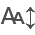

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)


In [3]:
# loading data
def load_data(filename="proshares_analysis_data.xlsx", directory="../data" ,sheet_name="hedge_fund_series"):
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        data = pd.read_excel(file_path, sheet_name=sheet_name,index_col=0,parse_dates=True)
        return data
    else:
        print("File not found.")
        return None


In [4]:
data =load_data(filename="spy_data.xlsx",sheet_name="total returns")
data.head()

SPY      ^IRX
date                          
1994-01-04  0.004035  0.000122
1994-01-05  0.002009  0.000122
1994-01-06  0.000000  0.000121
1994-01-07  0.006016  0.000119
1994-01-10  0.011960  0.000119

In [5]:
# Excess market returns

data["Excess Market Returns"] = data["SPY"] - data["^IRX"]
display("Excess Market Returns", data[["Excess Market Returns"]])

'Excess Market Returns'

Excess Market Returns
date                             
1994-01-04               0.003913
1994-01-05               0.001888
1994-01-06              -0.000121
1994-01-07               0.005897
1994-01-10               0.011841
...                           ...
2024-07-29               0.000384
2024-07-30              -0.005270
2024-07-31               0.016051
2024-08-01              -0.014364
2024-08-02              -0.018818

[7680 rows x 1 columns]

***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

In [6]:
def calculate_expanding_var(data: pd.DataFrame, start_date: str, column_name: str) -> pd.DataFrame:
    """
    Calculates the expanding window Value at Risk (VaR) for a given column in a DataFrame starting from a specific date.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the VaR.
    column_name (str): The name of the column in `data` for which VaR is to be calculated.
    
    Returns:
    pd.DataFrame: A DataFrame with the original values and their corresponding VaR values.
    """
    first_date = pd.to_datetime(start_date)
    calculation_data = data.loc[:first_date, column_name]
    
    var_series = data.loc[:,column_name].expanding(min_periods=len(calculation_data)).quantile(0.05).shift(1)
    
    combined_data = pd.concat([data.loc[first_date:, column_name], var_series], axis=1).dropna()
    combined_data.columns = [column_name, f"{column_name}_VaR_0.05"]
    
    return combined_data
VaR_df = calculate_expanding_var(data, '2000-12-29', 'Excess Market Returns')
display(VaR_df)
frequency = (VaR_df["Excess Market Returns_VaR_0.05"] > VaR_df["Excess Market Returns"]).value_counts()
display(frequency)
print(f"Frequency of Excess Market Returns below VaR: {frequency[True]}")

Excess Market Returns  Excess Market Returns_VaR_0.05
date                                                             
2001-01-02              -0.018329                       -0.017699
2001-01-03               0.047815                       -0.017794
2001-01-04              -0.010972                       -0.017792
2001-01-05              -0.032840                       -0.017789
2001-01-08               0.007540                       -0.017858
...                           ...                             ...
2024-07-29               0.000384                       -0.018511
2024-07-30              -0.005270                       -0.018510
2024-07-31               0.016051                       -0.018510
2024-08-01              -0.014364                       -0.018510
2024-08-02              -0.018818                       -0.018509

[5927 rows x 2 columns]

False    5639
True      288
Name: count, dtype: int64

Frequency of Excess Market Returns below VaR: 288


Historical VaR is not well-suited to predicting risks from extreme events that have not occurred in the past but could realistically happen in the future. Also, historical returns may not adequately reflect periods of increased market volatility. For instance, if the financial markets have been unusually calm, historical VaR might underestimate future risks. Furthermore, the effectiveness of the VaR estimate is highly dependent on the sample size and period it covers. Too short a time frame may not capture the full range of potential market behaviors, while too long a period may include outdated data that is no longer relevant.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

In [7]:
def calculate_expanding_vol(data: pd.DataFrame, start_date: str, column_name: str) -> pd.DataFrame:
    """
    Calculates the expanding window volatility for a given column in a DataFrame starting from a specific date,
    where volatility is defined as the square root of the sum of squared returns up to each point.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the volatility.
    column_name (str): The name of the column in `data` for which volatility is to be calculated.
    """
    first_date = pd.to_datetime(start_date)
    # calculation_data = data.loc[:first_date, column_name]
    
    vol_series = data.loc[:,column_name].expanding(min_periods=2).apply(lambda x: np.sqrt(np.sum(x**2)/ (len(x)-1))).shift(1)
    vol_series.name = f"{column_name}_expanding_window_volatility"
    

    
    return vol_series.loc[first_date:].dropna()
expanding_vol_df = calculate_expanding_vol(data, '2001-01-02', 'Excess Market Returns')
display(expanding_vol_df)


date
2001-01-02    0.011102
2001-01-03    0.011108
2001-01-04    0.011163
2001-01-05    0.011163
2001-01-08    0.011187
                ...   
2024-07-29    0.011913
2024-07-30    0.011912
2024-07-31    0.011911
2024-08-01    0.011912
2024-08-02    0.011912
Name: Excess Market Returns_expanding_window_volatility, Length: 5927, dtype: float64

In [8]:
def calculate_rolling_vol(data: pd.DataFrame, start_date: str, column_name: str, window_size: int =252) -> pd.DataFrame:
    """
    Calculates the expanding window volatility for a given column in a DataFrame starting from a specific date,
    where volatility is defined as the square root of the sum of squared returns up to each point.
    
    Args:
    data (pd.DataFrame): The input DataFrame containing financial time series data.
    start_date (str): The start date from which to begin calculating the volatility.
    column_name (str): The name of the column in `data` for which volatility is to be calculated.
    """
    first_date = pd.to_datetime(start_date)
    vol_series = data.loc[:,column_name].rolling(window=window_size,center=False).apply(lambda x: np.sqrt(np.sum(x**2)/ window_size)).shift(1)
    
    # combined_data = pd.concat([data.loc[first_date:, column_name], vol_series], axis=1).dropna()
    vol_series.name = f"{column_name}_rolling_window_volatility"
    return vol_series.loc[first_date:].dropna()
rolling_vol_df = calculate_rolling_vol(data, '2001-01-02', 'Excess Market Returns')
display(rolling_vol_df)

date
2001-01-02    0.015037
2001-01-03    0.015068
2001-01-04    0.015165
2001-01-05    0.015180
2001-01-08    0.015286
                ...   
2024-07-29    0.007293
2024-07-30    0.007280
2024-07-31    0.007263
2024-08-01    0.007332
2024-08-02    0.007385
Name: Excess Market Returns_rolling_window_volatility, Length: 5927, dtype: float64

In [9]:
# Exponential moving Avg
def ewma_volatility(data: pd.DataFrame, start_date: str, column_name:str, theta: float = 0.94, initial_sigma: float = 0.20 / np.sqrt(252)) -> pd.Series:
    """
    Calculate EWMA volatility.
    
    Args:
    data (pd.Series): Time series of returns.
    theta (float): Decay factor for the EWMA.
    initial_sigma (float): Initial volatility estimate.
    
    Returns:
    pd.Series: EWMA volatility of the returns.
    """
    calculation_data = data[column_name]
    sigma_squared = np.zeros_like(calculation_data)
    sigma_squared[0] = initial_sigma**2
    
    for t in range(1, len(calculation_data)):
        sigma_squared[t] = theta * sigma_squared[t-1] + (1 - theta) * calculation_data.iloc[t-1]**2
    new_data = pd.Series(np.sqrt(sigma_squared), index=data.index).loc[start_date:,]
    new_data.name = f"{column_name}_EWMA_volatility"

    
    return new_data

ewma_vol_df = ewma_volatility(data, '2001-01-02', 'Excess Market Returns')
display(ewma_vol_df)
display(pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1))

print(type(ewma_vol_df.index), type(rolling_vol_df.index), type(expanding_vol_df.index))


date
2001-01-02    0.016979
2001-01-03    0.017063
2001-01-04    0.020270
2001-01-05    0.019835
2001-01-08    0.020846
                ...   
2024-07-29    0.008455
2024-07-30    0.008198
2024-07-31    0.008052
2024-08-01    0.008741
2024-08-02    0.009176
Name: Excess Market Returns_EWMA_volatility, Length: 5927, dtype: float64

Excess Market Returns_expanding_window_volatility  \
date                                                            
2001-01-02                                           0.011102   
2001-01-03                                           0.011108   
2001-01-04                                           0.011163   
2001-01-05                                           0.011163   
2001-01-08                                           0.011187   
...                                                       ...   
2024-07-29                                           0.011913   
2024-07-30                                           0.011912   
2024-07-31                                           0.011911   
2024-08-01                                           0.011912   
2024-08-02                                           0.011912   

            Excess Market Returns_rolling_window_volatility  \
date                                                          
2001-01-02                                         0.015037   
2001-01-03                                         0.015068   
2001-01-04                                         0.015165   
2001-01-05                                         0.015180   
2001-01-08                                         0.015286   
...                                                     ...   
2024-07-29                                         0.007293   
2024-07-30                                         0.007280   
2024-07-31                                         0.007263   
2024-08-01                                         0.007332   
2024-08-02                                         0.007385   

            Excess Market Returns_EWMA_volatility  
date                                               
2001-01-02                               0.016979  
2001-01-03                               0.017063  
2001-01-04                               0.020270  
2001-01-05                               0.019835  
2001-01-08                               0.020846  
...                                           ...  
2024-07-29                               0.008455  
2024-07-30                               0.008198  
2024-07-31                               0.008052  
2024-08-01                               0.008741  
2024-08-02                               0.009176  

[5927 rows x 3 columns]

<class 'pandas.core.indexes.datetimes.DatetimeIndex'> <class 'pandas.core.indexes.datetimes.DatetimeIndex'> <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


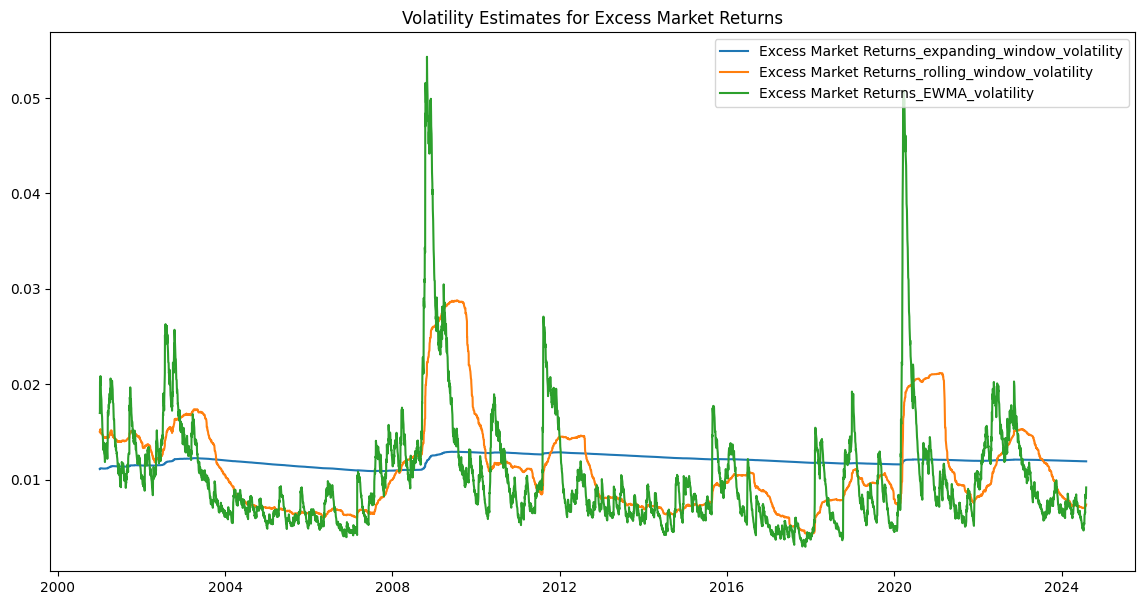

In [10]:
plot_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
plt.figure(figsize=(14, 7))
plt.plot(plot_data)
plt.title("Volatility Estimates for Excess Market Returns")
plt.legend(plot_data.columns)
plt.show()

In [11]:
# One day ahead Var

combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
one_day_ahead_data = combined_data.apply(lambda x: x *(-1.65),axis=0)
one_day_ahead_combined_data = pd.concat([data.loc[pd.to_datetime('2001-01-02'):,"Excess Market Returns"], one_day_ahead_data], axis=1)
one_day_ahead_combined_data
one_day_ahead_combined_data.eval("""
                                 VaR_Expanding = `Excess Market Returns` < `Excess Market Returns_expanding_window_volatility`
                                 VaR_Rolling = `Excess Market Returns` < `Excess Market Returns_rolling_window_volatility`
                                 VaR_EWMA = `Excess Market Returns` < `Excess Market Returns_EWMA_volatility`
                                 """, inplace=True)
one_day_ahead_combined_data.loc[:,["VaR_Expanding","VaR_Rolling","VaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]

VaR_Expanding    273
VaR_Rolling      313
VaR_EWMA         355
Name: True, dtype: int64

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

In [12]:
from scipy.stats import norm
z_score= 0.05
quantile_level = 0.05
combined_data = pd.concat([expanding_vol_df, rolling_vol_df, ewma_vol_df], axis=1)
one_day_ahead_data = combined_data.apply(lambda x: x *(-norm.pdf(z_score)/quantile_level),axis=0)
one_day_ahead_combined_data = pd.concat([data.loc[pd.to_datetime('2001-01-02'):,"Excess Market Returns"], one_day_ahead_data], axis=1)
one_day_ahead_combined_data
one_day_ahead_combined_data.eval("""
                                 CVaR_Expanding = `Excess Market Returns` < `Excess Market Returns_expanding_window_volatility`
                                 CVaR_Rolling = `Excess Market Returns` < `Excess Market Returns_rolling_window_volatility`
                                 CVaR_EWMA = `Excess Market Returns` < `Excess Market Returns_EWMA_volatility`
                                 """, inplace=True)
one_day_ahead_combined_data.loc[:,["CVaR_Expanding","CVaR_Rolling","CVaR_EWMA"]].apply(pd.Series.value_counts).iloc[1]

CVaR_Expanding    3
CVaR_Rolling      3
CVaR_EWMA         2
Name: True, dtype: int64

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [13]:
# from arch import arch_model
# from dask.distributed import Client

# results = {}

# # Set end location for rolling window
# end_loc = np.where(data.index >= pd.to_datetime('2000-12-29'))[0].min()

# # Define GARCH model
# am = arch_model(data["Excess Market Returns"], vol='Garch', p=1, q=1, dist='Normal')

# # Function to fit GARCH model and forecast variance
# def fit_garch(first_obs, last_obs):
#     res = am.fit(first_obs=first_obs, last_obs=last_obs, disp='off')
#     temp = res.forecast(horizon=1).variance
#     return temp.iloc[0]

# # Use a with-statement to automatically manage the Dask client
# with Client() as client:
#     print(client.ncores())
#     print(client.nthreads)

#     # Submit GARCH fitting tasks to Dask
#     futures = []
#     for i in range(len(data["Excess Market Returns"]) - end_loc):
#         future = client.submit(fit_garch, i, i + end_loc)
#         futures.append(future)

#     # Collect results as they complete
#     results = [future.result() for future in futures]

# # Convert results into a DataFrame
# forecast_df = pd.concat(results, axis=0).reset_index(drop=True)
# forecast_df.columns = ["Forecast Variance"]

# # Display the cleaned-up DataFrame
# print(forecast_df.head())
    

In [14]:
len(forecast_df)

NameError: name 'forecast_df' is not defined

In [29]:
len(data.loc[:'2001-01-02', "Excess Market Returns"])

1754